In [1]:
#from pyedflib import EdfReader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Add path to the pygazeanalyser clone folder from github 
import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')
sys.path.append('C:\\Users\\adith\\OneDrive\\Desktop\\PyEDF Example')


In [3]:
from pygaze import *
from edfreader import *
from gazeplotter import *
#from edfreader import *

In [4]:
#read data using read_edf function
fname = 'C:\\Users\\adith\\OneDrive\\Desktop\\PyEDF Example\\G002_7.asc' #path of the ASC file
data = read_edf(fname,start='START',stop='END') #start and stop indicators can be found in the ASC file

In [5]:
data[6]

{'x': array([0., 0., 0., ..., 0., 0., 0.]),
 'y': array([0., 0., 0., ..., 0., 0., 0.]),
 'size': array([0., 0., 0., ..., 0., 0., 0.]),
 'time': array([   0,    1,    2, ..., 5880, 5881, 5882]),
 'trackertime': array([1736296, 1736297, 1736298, ..., 1742176, 1742177, 1742178]),
 'events': {'Sfix': [1736308,
   1736308,
   1736374,
   1736375,
   1736591,
   1736592,
   1738169,
   1738169,
   1738616,
   1738618,
   1739139,
   1739148,
   1739454,
   1739454,
   1739699,
   1739701,
   1740121,
   1740221,
   1740411,
   1740423,
   1740718,
   1740718,
   1741259,
   1741267,
   1741926,
   1741943],
  'Ssac': [1736353,
   1736354,
   1736576,
   1736577,
   1738145,
   1738147,
   1738578,
   1738579,
   1739032,
   1739035,
   1739411,
   1739411,
   1739673,
   1739673,
   1740087,
   1740087,
   1740280,
   1740292,
   1740685,
   1740686,
   1741096,
   1741097,
   1741769,
   1741770,
   1742087,
   1742088],
  'Sblk': [1739066,
   1739082,
   1740305,
   1740312,
   1741141,
  

### Efix

In [6]:
#Retrieve Efix list ([starttime, endtime, duration, endx, endy])
Efix = np.array(data[0]['events']['Efix'])


#Retrieve duration,endx,endy
plt_data = Efix[:,2:]
duration = plt_data[:,0] 
x = plt_data[:,1] 
y = plt_data[:,2] 

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


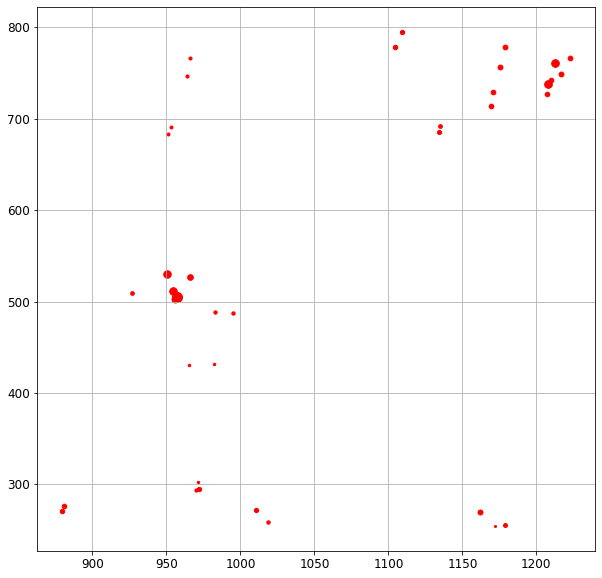

In [7]:
#plot
fig,ax = plt.subplots(figsize =(10,10))
duration_max = np.max(duration)
ax.grid()
for duration,x,y in plt_data:
    marker_size = duration/duration_max * 100
    ax.scatter(x,y,s=marker_size,c='red')


### Saccade

In [8]:
#Retrieve ESac list ([starttime, endtime, duration, startx, starty, endx, endy])
Esac = np.array(data[0]['events']['Esac'])


#Retrieve duration,endx,endy
plt_data = Esac[:,2:]
duration = plt_data[:,0] 
x_start = plt_data[:,1] 
y_start = plt_data[:,2]
x_end = plt_data[:,3]
y_end = plt_data[:,4]

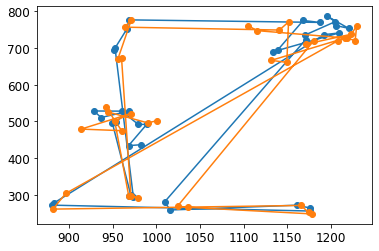

In [9]:
#plot
#fig,ax = plt.subplots(figsize =(10,10))
duration_max = np.max(duration)
#ax.grid()
#for d,x1,y1,x2,y2 in plt_data:
    #linewidth = duration/duration_max * 100
    #plt.plot(x1,y1,x2,y2,marker='o')
    #plt.scatter(x_end,y_end,'go-',linewidth=linewidth)

plt.plot(x_start,y_start,x_end,y_end,marker='o')
#plt.show()

In [10]:
x_new = np.array([x_start,x_end]).reshape(2,-1).T.reshape(-1)
y_new = np.array([y_start,y_end]).reshape(2,-1).T.reshape(-1)

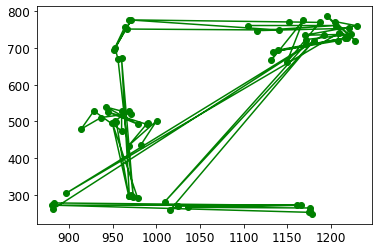

In [11]:
plt.plot(x_new,y_new,'-go')

### Particpant ID: G036

In [12]:
#read data using read_edf function
fname = 'Participant Data/G36_asc/G036_1.asc' #path of the ASC file
data = read_edf(fname,start='START',stop='END') #start and stop indicators can be found in the ASC file

In [13]:
len(data)

18

In [14]:
#Retrieve ESac list ([starttime, endtime, duration, startx, starty, endx, endy])
Esac = np.array(data[1]['events']['Esac'])


#Retrieve duration,endx,endy
plt_data = Esac[:,2:]
duration = plt_data[:,0] 
x_start = plt_data[:,1] 
y_start = plt_data[:,2]
x_end = plt_data[:,3]
y_end = plt_data[:,4]

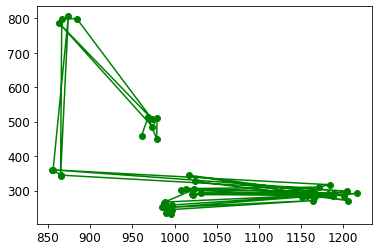

In [15]:
#plot
#fig,ax = plt.subplots(figsize =(10,10))
duration_max = np.max(duration)
#ax.grid()
#for d,x1,y1,x2,y2 in plt_data:
    #linewidth = duration/duration_max * 100
    #plt.plot(x1,y1,x2,y2,marker='o')
    #plt.scatter(x_end,y_end,'go-',linewidth=linewidth)
x_new = np.array([x_start,x_end]).reshape(2,-1).T.reshape(-1)
y_new = np.array([y_start,y_end]).reshape(2,-1).T.reshape(-1)
plt.plot(x_new,y_new,'-go')#plt.show()

#### Using Gazeplotter

In [24]:
import sys
sys.path.append('PyGazeAnalyser-master\\pygazeanalyser')
from pygaze import *
from edfreader import *
from gazeplotter import *
#from edfreader import *
# Add path to the pygazeanalyser clone folder from github 
import numpy as np
#sys.path.append('C:\\Users\\adith\\OneDrive\\Desktop\\PyEDF Example')
import time

In [35]:
#participant details
partic_id = 'G036'
game_nr  = 1

#read data using read_edf function
fname = 'Participant Data/'+str(partic_id)+ '/' + str(partic_id) + \
         str('_') + str(game_nr) + str('.asc') #path of the ASC file
data = read_edf(fname,start='START',stop='END') #start and stop indicators can be found in the ASC file

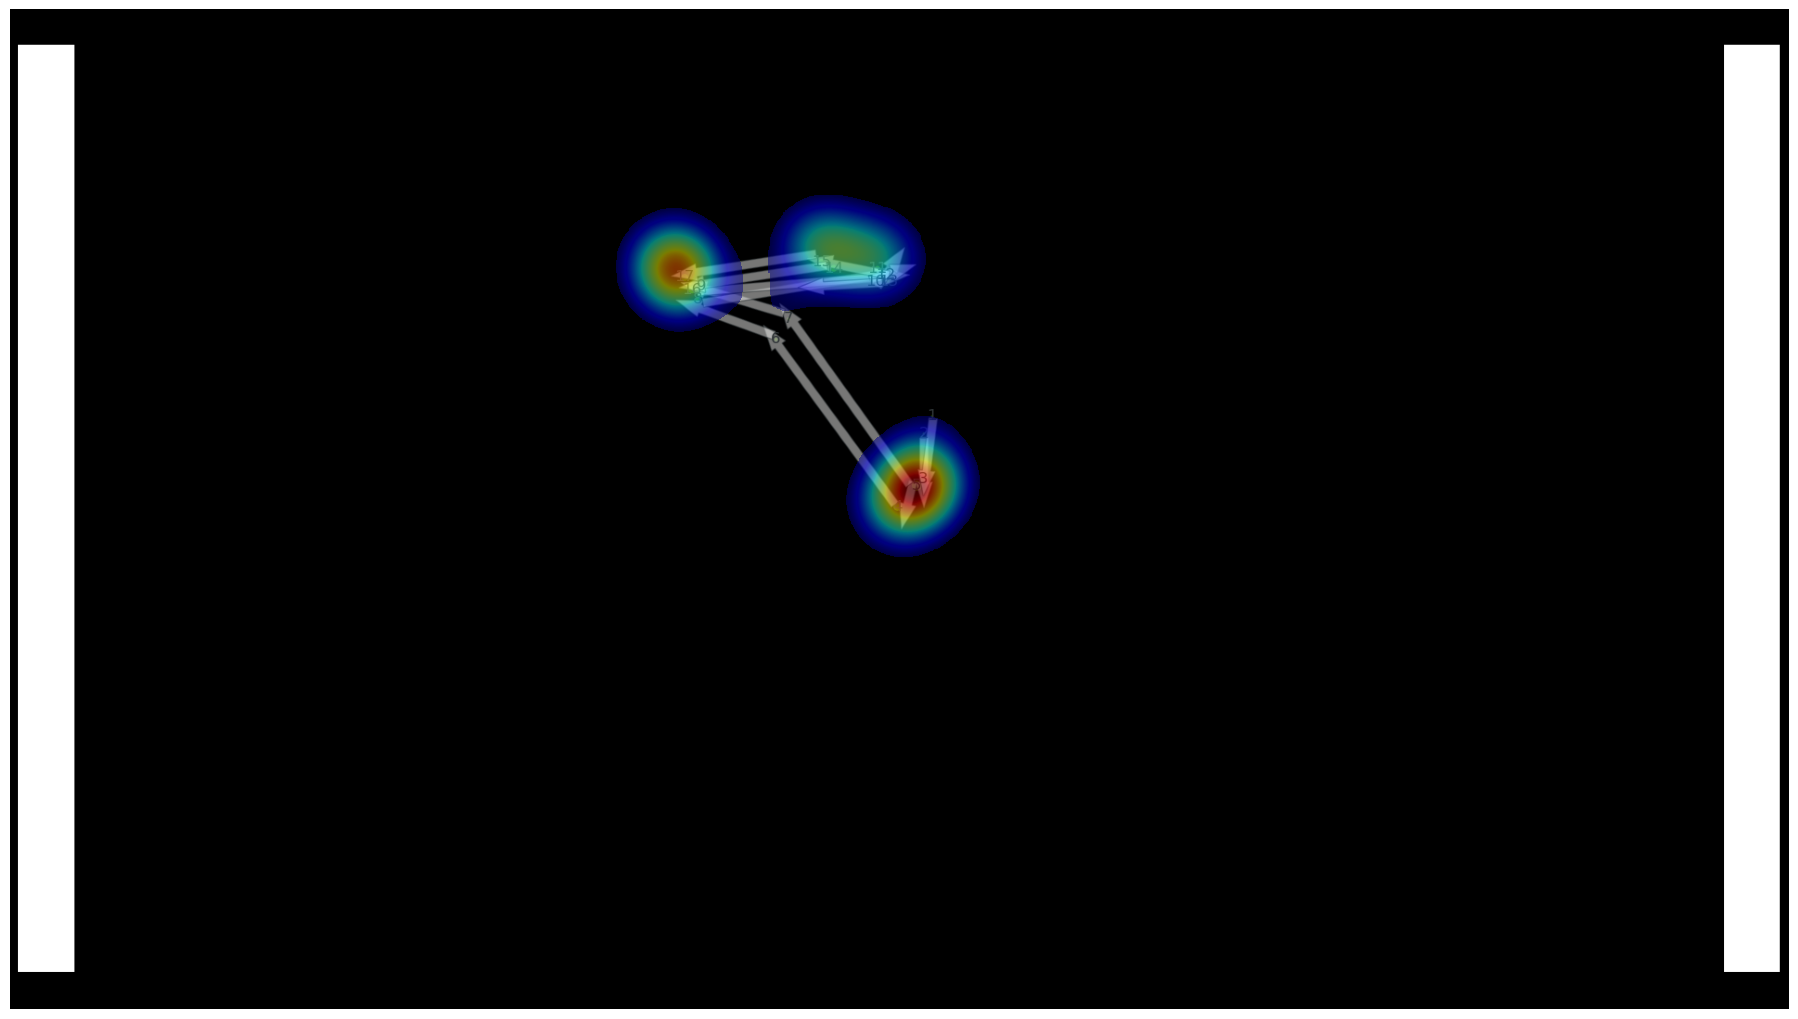

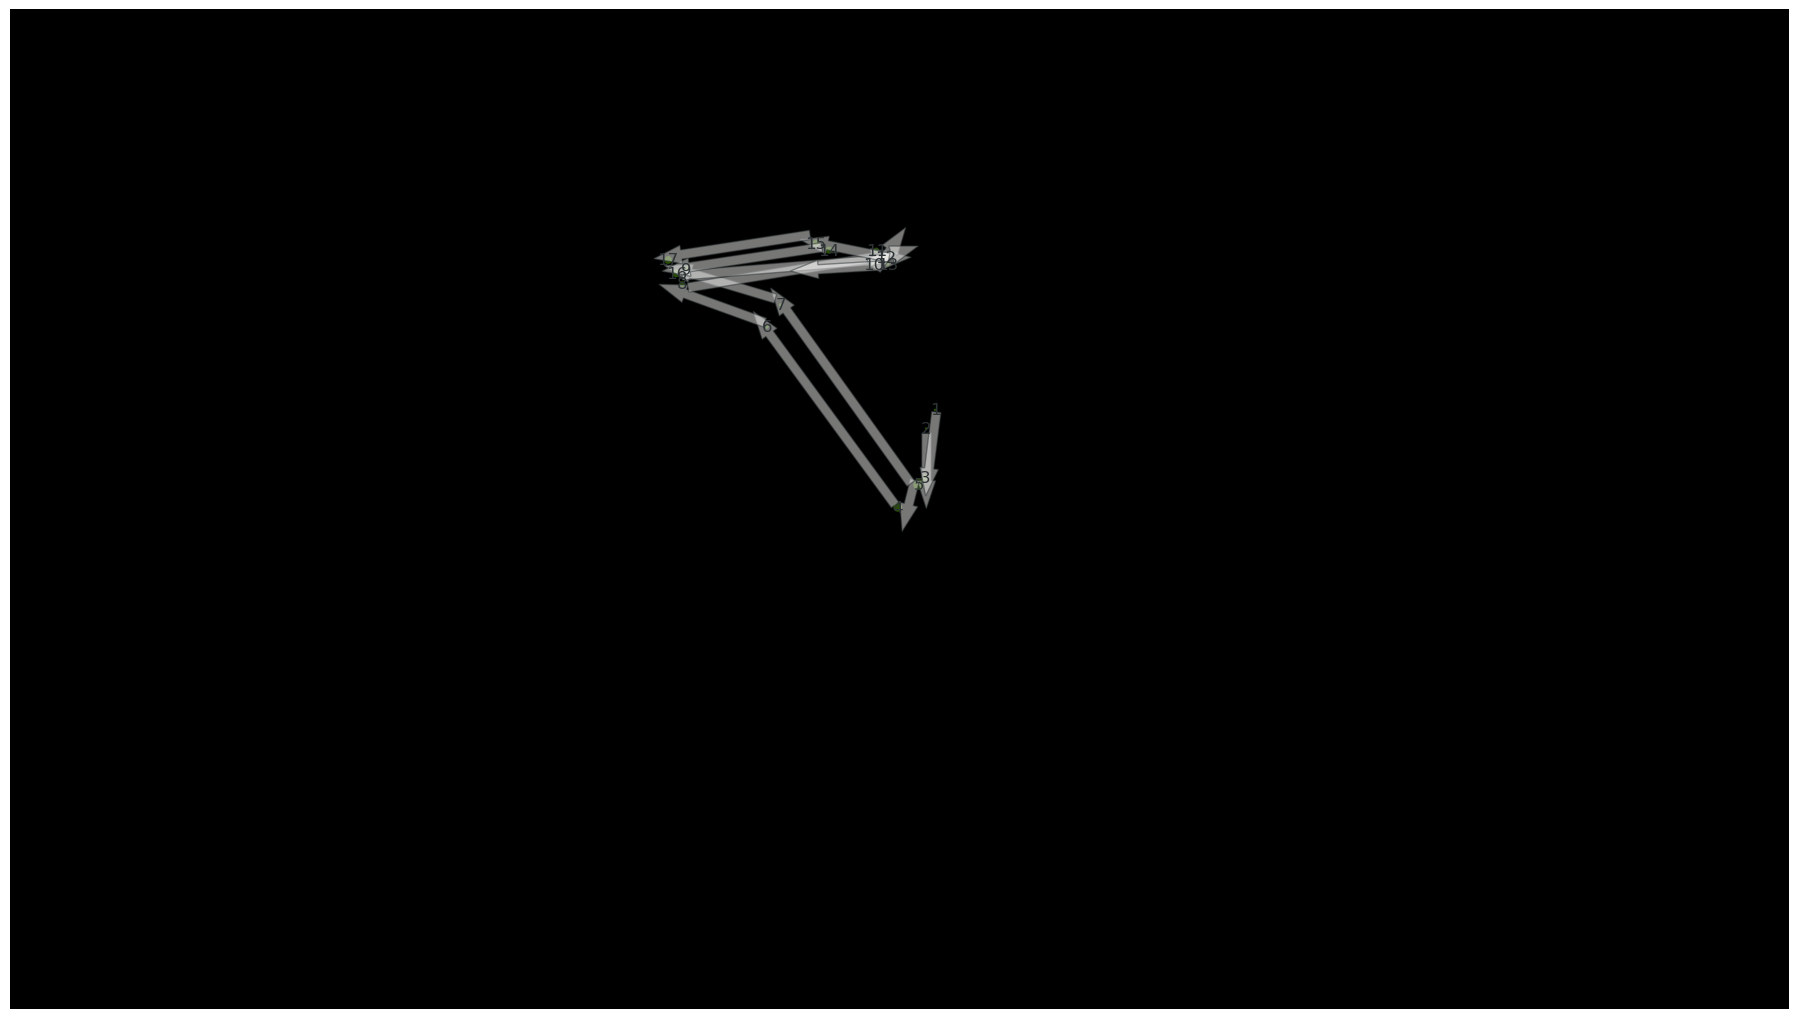

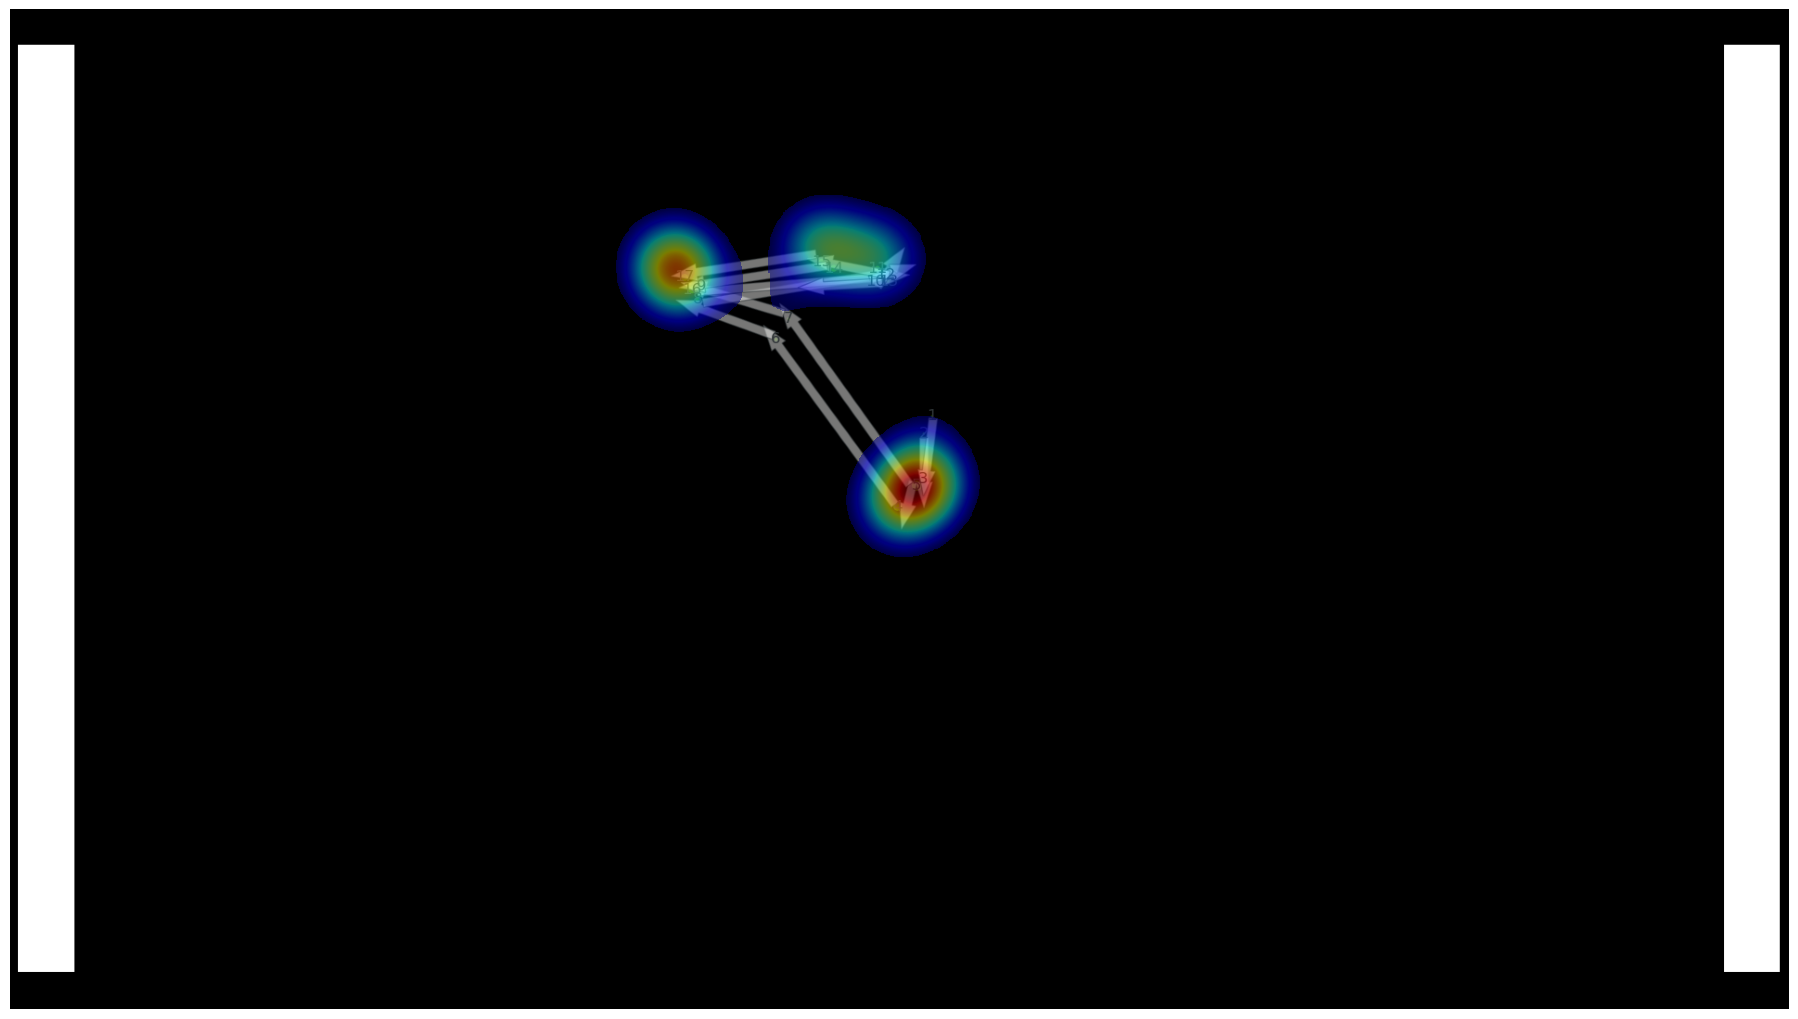

In [39]:
trial_nr = 15
#saccades and fixations
saccades = np.array(data[trial_nr]['events']['Esac'])
fixations = np.array(data[trial_nr]['events']['Efix'])
dispsize= (1919,1079) # (px,px)# changed to even numbers

# draw saccadic scanpath and save fig
savefilename = str(partic_id) + '_game_'+str(game_nr)+'_' \
               + str(trial_nr) + '_'+ time.strftime("%Y%m%d-%H%M%S")
fig = draw_scanpath(fixations, saccades, dispsize, imagefile=None, alpha=0.5, savefilename=savefilename)

#draw heatmap on top of it
img_file = savefilename + '.png'
draw_heatmap(fixations, dispsize, imagefile=img_file)



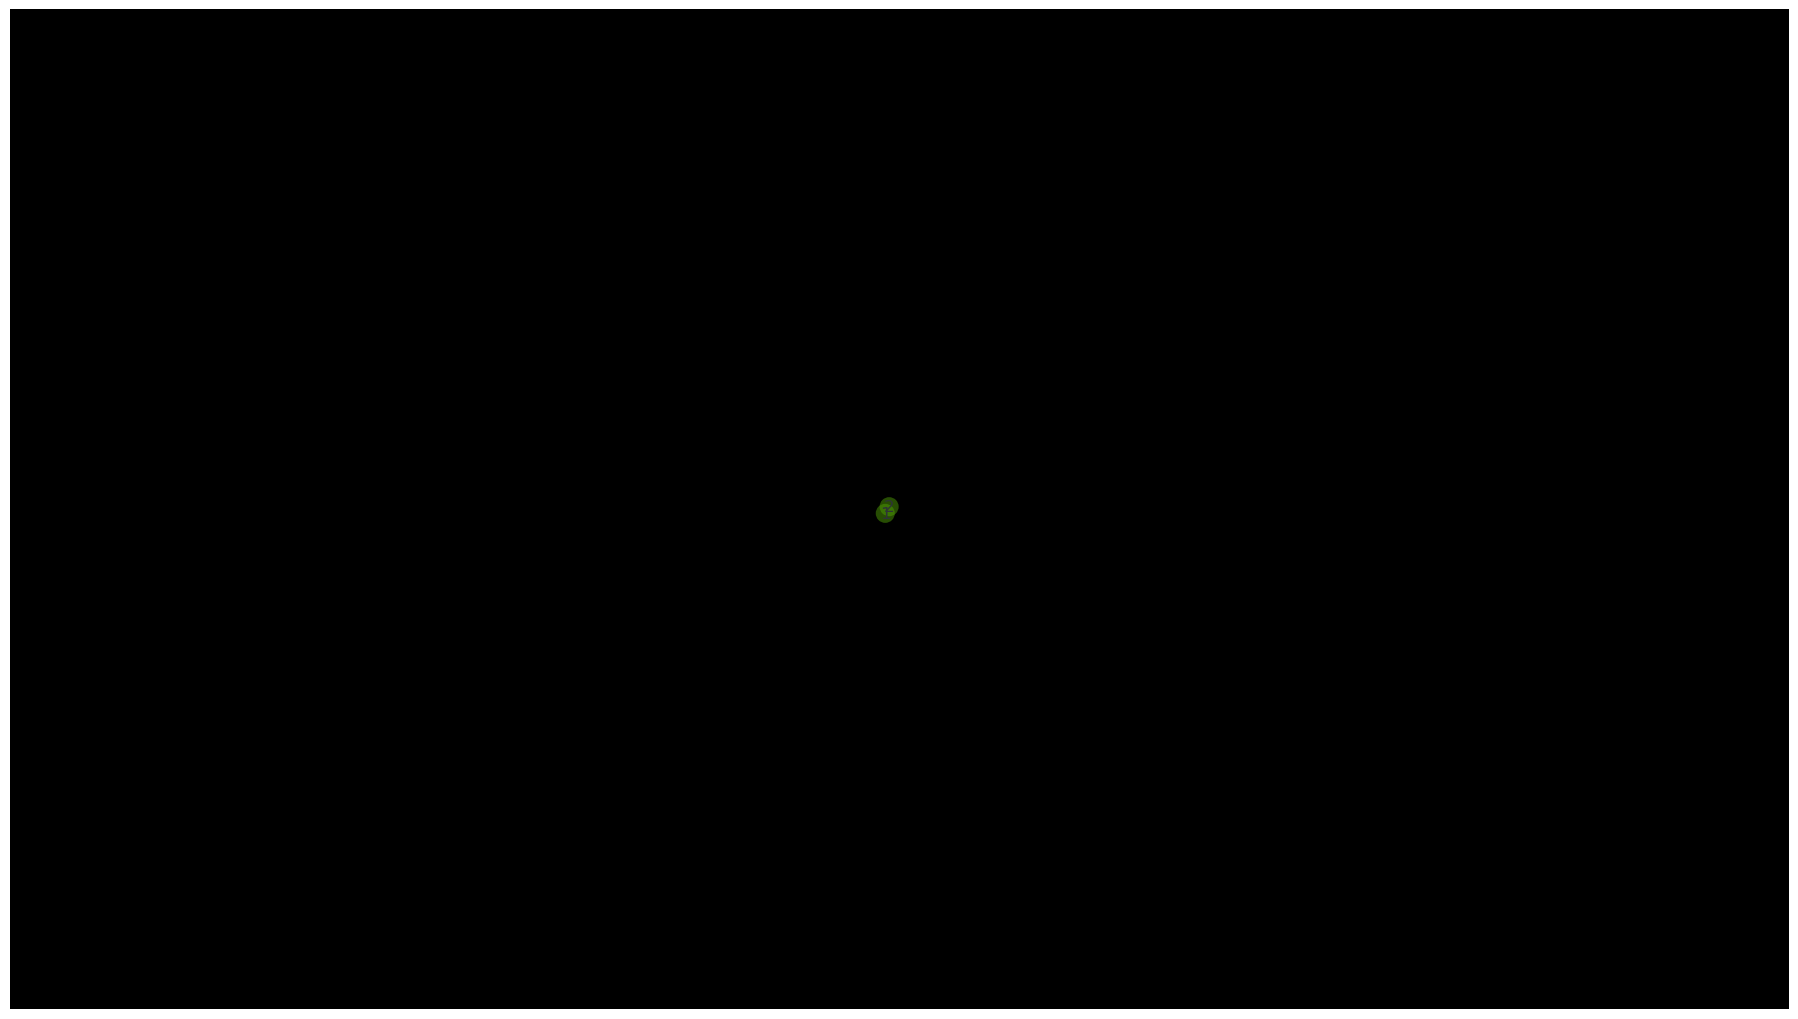

In [38]:
fig

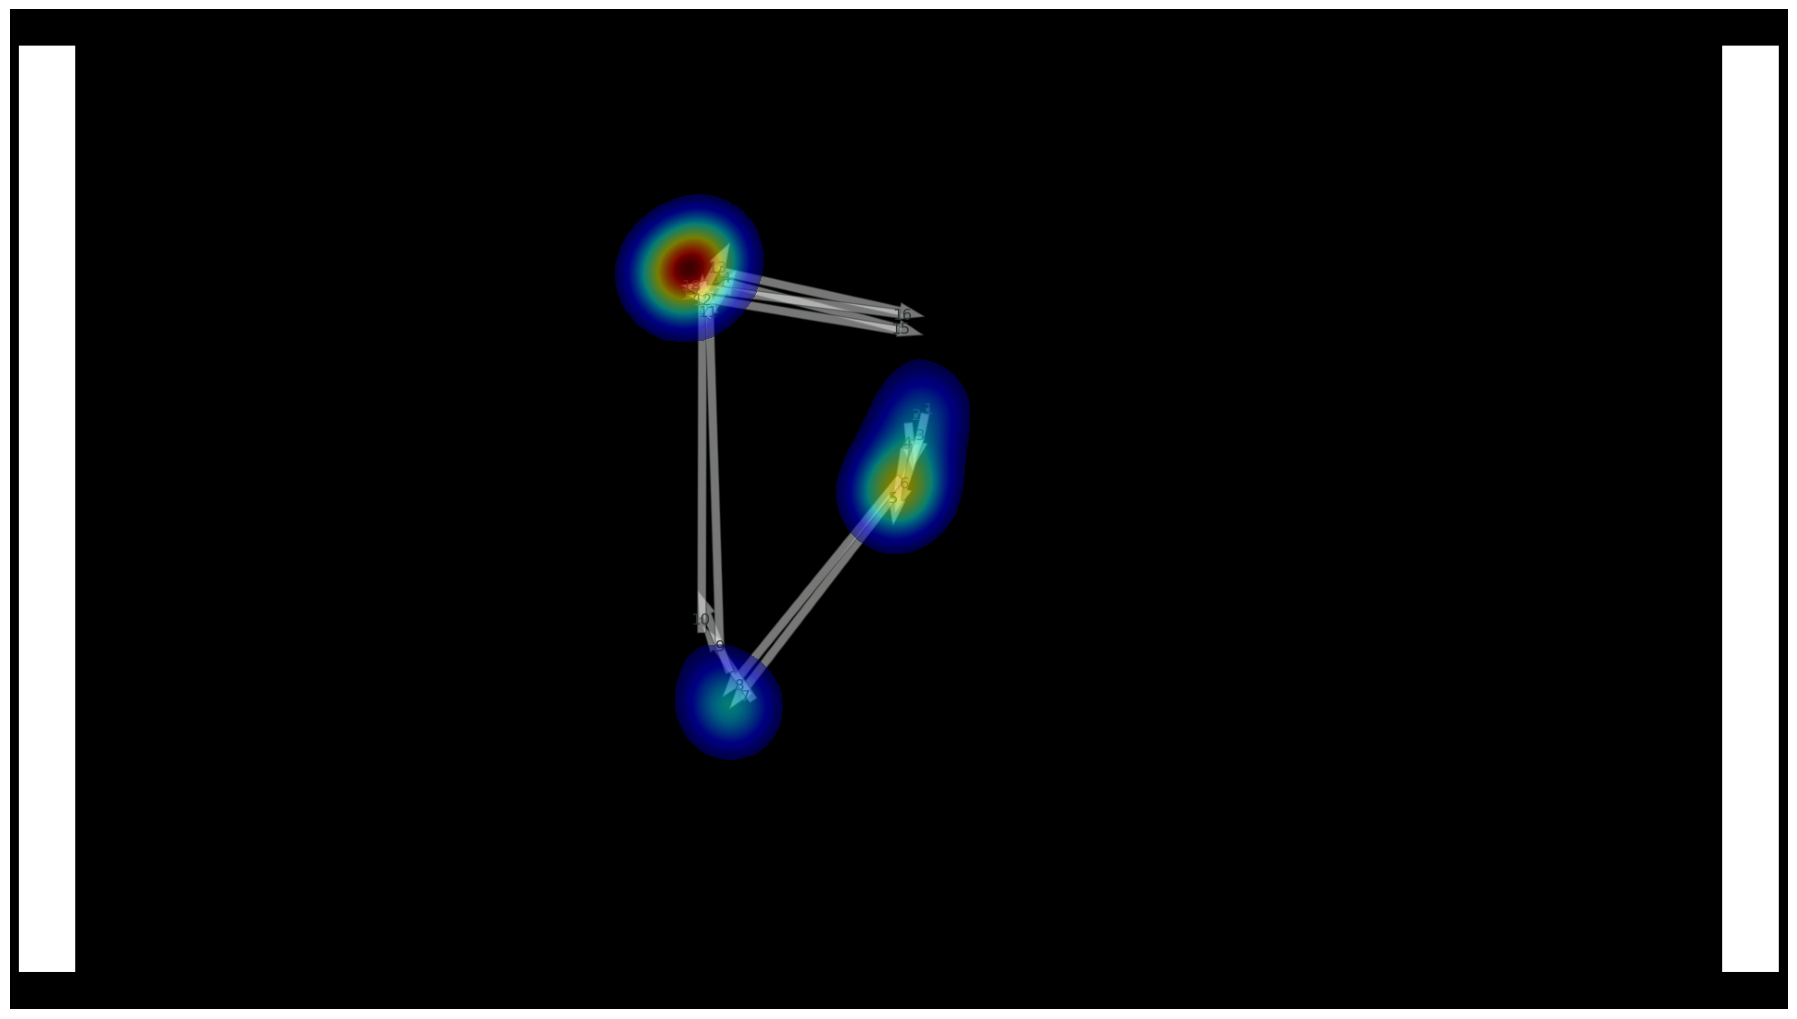

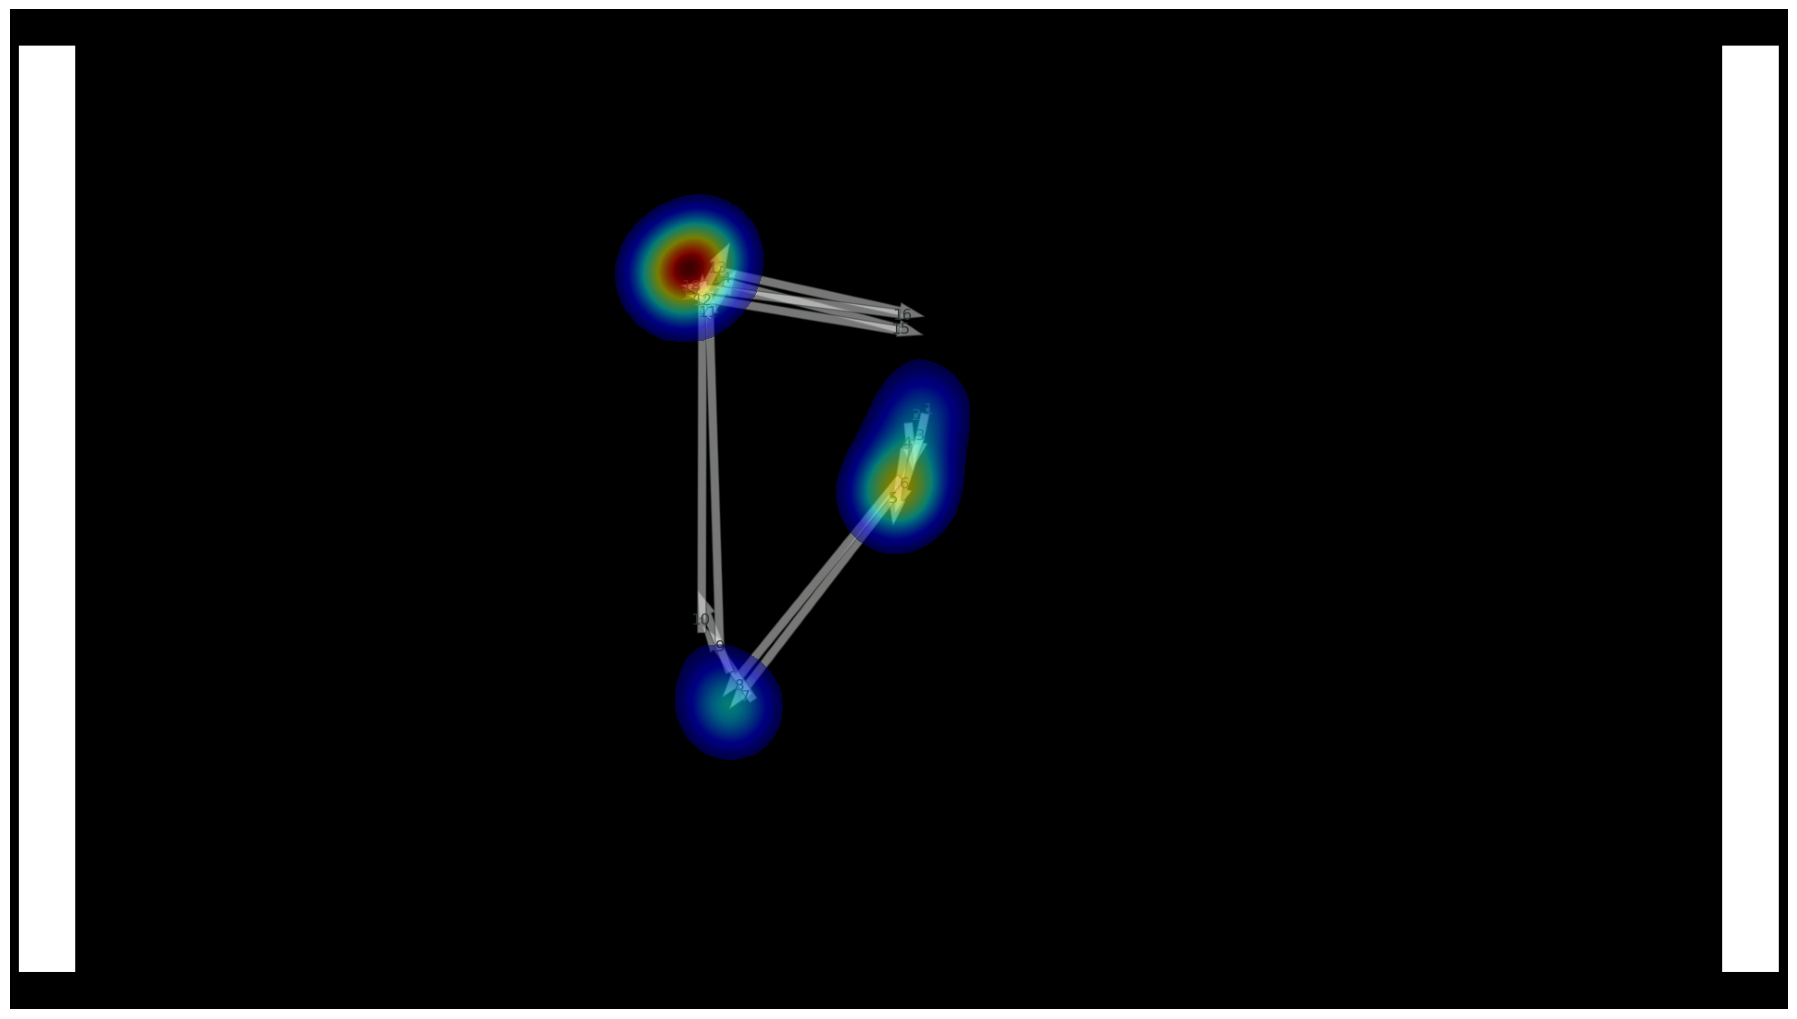

In [23]:
#dispsize= (int(1919),int(1079)) # (px,px)
draw_heatmap(fixations, dispsize, imagefile='scanpath_2.png')


### Different Trial Numbers 

### Sija's Code

In [20]:
# analysis script for eye tracking project
#
# version 4 (Apr 2021)
#
# looks all the data from Start to End

__author__ = "Sijamini Baskaralingam"

# native
import os

# custom
from edfreader import read_edf
from gazeplotter import draw_fixations, draw_heatmap, draw_scanpath, draw_raw

# external
import numpy


# # # # #
# CONSTANTS

# PARTICIPANTS
PP = str(input("participant ID?: "))
PPS = [PP+"_1", PP+"_2", PP+"_3", PP+"_4", PP+"_5", PP+"_6", PP+"_7", PP+"_8", PP+"_9", PP+"_10", PP+"_11", PP+"_12", PP+"_13", PP+"_14", PP+"_15", PP+"_16"]
print(PPS)

# DIRECTORIES
# paths
__file__ = 'C:\\Users\\adith\\OneDrive\\Documents\\Courses\\ETH\\Neural Systems\\Course Project\\pygazeanalyser\\data'
DIR = os.path.dirname(__file__)
IMGDIR = os.path.join(DIR, 'imgs')
DATADIR = os.path.join(DIR, 'data')
PLOTDIR = os.path.join(DIR, 'plots')
OUTPUTFILENAME = os.path.join(DIR, "output.txt")
# check if the image directory exists
if not os.path.isdir(IMGDIR):
	raise Exception("ERROR: no image directory found; path '%s' does not exist!" % IMGDIR)
# check if the data directory exists
if not os.path.isdir(DATADIR):
	raise Exception("ERROR: no data directory found; path '%s' does not exist!" % DATADIR)
# check if output directorie exist; if not, create it
if not os.path.isdir(PLOTDIR):
	os.mkdir(PLOTDIR)

# DATA FILES
SEP = '\t' # value separator
EDFSTART = "START" # EDF file trial start message
EDFSTOP = "END" # EDF file trial end message
TRIALORDER = [EDFSTART, 'image online','image offline', EDFSTOP]
INVALCODE = 0.0 # value coding invalid data

# EXPERIMENT SPECS
DISPSIZE = (1919,1079) # (px,px)
SCREENSIZE = (53.3,29.9) # (cm,cm)
SCREENDIST = 27 # cm
PXPERCM = numpy.mean([DISPSIZE[0]/SCREENSIZE[0],DISPSIZE[1]/SCREENSIZE[1]]) # px/cm


# # # # #
# READ FILES

# loop through all participants
for ppname in PPS:
	
	print("starting data analysis for participant '%s'" % (ppname))

	# BEHAVIOUR
	#print("loading behavioural data")
	
	# path
	#fp = os.path.join(DATADIR, '%s.txt' % ppname)
	
	# open the file
	#fl = open(fp, 'r')
	
	# read the file content
	#data = fl.readlines()
	
	# close the file
	#fl.close()
	
	# separate header from rest of file
	#header = data.pop(0)
	#header = header.replace('\n','').replace('\r','').replace('"','').split(SEP)
	
	# process file contents
	#for i in range(len(data)):
	#	data[i] = data[i].replace('\n','').replace('\r','').replace('"','').split(SEP)
	
	# GAZE DATA
	print("loading gaze data")
	
	# path
	fp = os.path.join(DATADIR, '%s.asc' % ppname)
	
	# check if the path exist
	if not os.path.isfile(fp):
		# if not, check if the EDF exists
		edfp = os.path.join(DATADIR, '%s.edf' % ppname)
		if os.path.isfile(edfp):
			# if it does, convert if usinf edf2asc.exe
			os.system("edf2asc %s" % edfp)
			# load ASCII
			fp = os.path.join(DATADIR, '%s.asc' % ppname)
		# if it does not exist, raise an exception
		else:
			raise Exception("No eye data file (neither ASC, nor EDF) file found for participant '%s' (tried paths:\nASC: %s\nEDF: %s" % (ppname, fp, edfp))
	
	# read the file
	#edfdata[trialnr]['time'] = list of timestamps in trialnr
	#edfdata[trialnr]['size'] = list of pupil size samples in trialnr
	edfdata = read_edf(fp, EDFSTART, stop=EDFSTOP, missing=INVALCODE, debug=False)
	
	# NEW OUTPUT DIRECTORIES
	# create a new output directory for the current participant
	pplotdir = os.path.join(PLOTDIR, ppname)
	# check if the directory already exists
	if not os.path.isdir(pplotdir):
		# create it if it doesn't yet exist
		os.mkdir(pplotdir)


	# # # # #
	# PLOTS
	
	print("plotting gaze data")

        # load image name, saccades, and fixations
	#imgname = data[trialnr][header.index("image")]
	imgname=None
	saccades=[]
	fixations=[]

	# loop through trials
	for trialnr in range(0,16):
		saccades_temp = edfdata[trialnr]['events']['Esac'] # [starttime, endtime, duration, startx, starty, endx, endy]
		fixations_temp = edfdata[trialnr]['events']['Efix'] # [starttime, endtime, duration, endx, endy]
		saccades = saccades + saccades_temp
		fixations = fixations + fixations_temp
		print("Saccades: ", saccades)
		print("Fixation: ", fixations)
		
	# paths
	#imagefile = os.path.join(IMGDIR,imgname)
	imagefile = None
	#rawplotfile = os.path.join(pplotdir, "raw_data_%s_%d" % (ppname,trialnr))
	#scatterfile = os.path.join(pplotdir, "fixations_%s_%d" % (ppname,trialnr))
	#scanpathfile =  os.path.join(pplotdir, "scanpath_%s_%d" % (ppname,trialnr))
	heatmapfile = os.path.join(pplotdir, "heatmap_%s_%d" % (ppname,trialnr))
	
	# raw data points
	#draw_raw(edfdata[trialnr]['x'], edfdata[trialnr]['y'], DISPSIZE, imagefile=imagefile, savefilename=rawplotfile)

	# fixations
	#draw_fixations(fixations, DISPSIZE, imagefile=imagefile, durationsize=True, durationcolour=False, alpha=0.5, savefilename=scatterfile)
	
	# scanpath
	#draw_scanpath(fixations, saccades, DISPSIZE, imagefile=imagefile, alpha=0.5, savefilename=scanpathfile)

	# heatmap		
	draw_heatmap(fixations, DISPSIZE, imagefile=imagefile, durationweight=True, alpha=0.5, savefilename=heatmapfile)


KeyboardInterrupt: Interrupted by user